In [1]:
import kooplearn
import kooplearn.datasets
import matplotlib.pyplot as plt


/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
import math
from pathlib import Path
from typing import Optional

import numpy as np
import scipy
import scipy.sparse
from scipy.integrate import romb
from scipy.special import binom
from scipy.stats.sampling import NumericalInversePolynomial

from kooplearn._src.utils import topk
from kooplearn.datasets.misc import (
    DataGenerator,
    DiscreteTimeDynamics,
    LinalgDecomposition,
)
import tqdm

from kooplearn.datasets.stochastic import LangevinTripleWell1D,MullerBrownPotential



In [3]:

def return_analytical_forces(vec):
    x = vec[:,0]
    y = vec[:,1]
    forces_x = 0.15*(400*(x-1)*np.exp(-(x-1)**2-10*y**2)+200*x*np.exp(-x**2-10*(y-0.5)**2)-170*(-6.5*2*(0.5+x)+11*(y-1.5))*np.exp(-6.5*(0.5+x)**2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)**2)+15*(0.7*2*(x+1)+0.6*(y-1))*np.exp(0.7*(1+x)**2+0.6*(1+x)*(y-1)+0.7*(y-1)**2))
    forces_y = 0.15*(4000*np.exp(-(x-1)**2-10*y**2)+2000*(y-0.5)*np.exp(-x**2-10*(y-0.5)**2)-170*(11*(x+0.5)-6.5*2*(y-1.5))*np.exp(-6.5*(0.5+x)**2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)**2)+15*(0.6*(1+x) +0.7*2*(y-1))*np.exp(0.7*(1+x)**2+0.6*(1+x)*(y-1)+0.7*(y-1)**2))
    return np.concatenate((-forces_x[:,np.newaxis],-forces_y[:,np.newaxis]),axis=1)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
scler_samp = MinMaxScaler()
gamma = 10
dt = 0.005
sample = np.loadtxt("/home/tdevergne@iit.local/Documents/test_michele_committor/muller/test_vel/COLVAR")[:,1:3]
forces = -np.loadtxt("/home/tdevergne@iit.local/Documents/test_michele_committor/muller/test_vel/deriv")[:,2].reshape(sample.shape[0],2)

print(sample.shape)
velocities = np.diff(sample,axis=0)/dt
print(velocities.shape)

total_sample = np.hstack((velocities,sample[1:]))
true_forces = return_analytical_forces(sample)
total_forces = np.hstack((forces[1:]-gamma*velocities ,velocities))


(10000001, 2)
(10000000, 2)


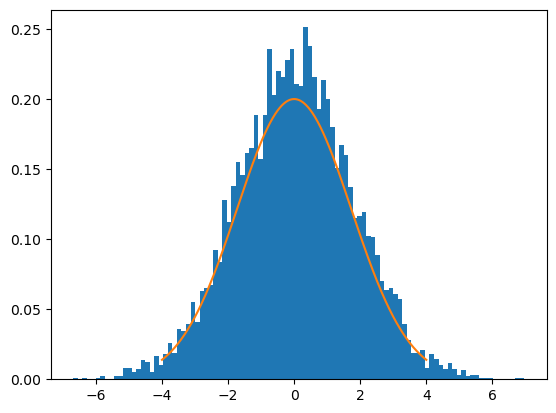

In [5]:
plt.hist(velocities[:700000:100,1],bins=100,density=True)#,sample[:4000000:10,1])
x= np.linspace(-4,4,1000)
plt.plot(x,0.2*np.exp(-x**2/6))

In [6]:
sample.shape

(10000001, 2)

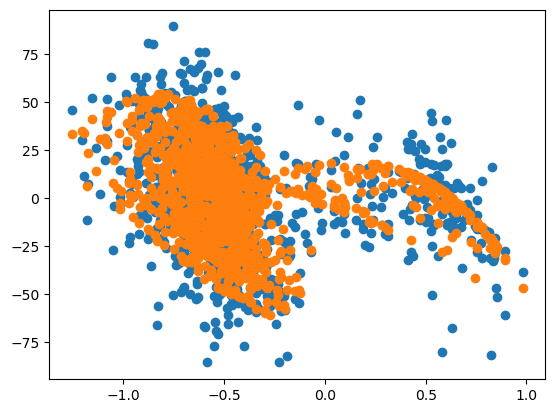

In [7]:
plt.scatter(sample[1::10000,0],total_forces[::10000,0])
plt.scatter(sample[1::10000,0],forces[1::10000,0])

In [8]:
from sklearn.gaussian_process.kernels import RBF
from kooplearn.data import traj_to_contexts
from kooplearn.models import kernel_generator
#0.2 1e-2 1000 PCR
kernel = RBF(length_scale=np.array([5.0,5.0,0.3,0.3])) #0.345 works  well #0.4 best

print(kernel.length_scale)

model = kooplearn.models.kernel_generator.KernelInverseGenerator(kernel, reduced_rank=False, eta=5e-4, rank=15
                                   
                                   , tikhonov_reg=5e-1)

[5.  5.  0.3 0.3]


In [9]:
def force(x):
    return -40*x*(x**2-1)
test=total_sample[::1000]
train_data = traj_to_contexts(test)
forces_train = traj_to_contexts(total_forces[::1000])
train_data.shape
friction = np.array([2*3*10.0,2*3*10.0,0.0,0.0])


In [10]:
train_data.shape

(9999, 2, 4)

In [11]:
model_no_correction = model.fit(train_data,forces=(forces_train),friction=friction) #np.sqrt(2))


Fitted KernelInverseGenerator model. Lookback length set to 1


In [12]:
vals_gen,vecs_gen = model.eig(eval_right_on=train_data[:,:1, ...])


In [13]:
print((1e-4-1/vals_gen)[-10:])
print(vals_gen)


[-4.10678195-3.68124242j -4.10678195+3.68124242j -3.33141735-3.40731862j
 -3.33141735+3.40731862j -4.22601916+0.j         -2.95419697+0.j
 -2.25519932+0.j         -0.65078342+0.j         -0.04171564+0.j
 -0.01236057+0.j        ]
[2.33832398e-02-0.08321836j 2.33832398e-02+0.08321836j
 4.65727096e-02-0.08646968j 4.65727096e-02+0.08646968j
 1.21938812e-01+0.j         1.35014746e-01-0.12102174j
 1.35014746e-01+0.12102174j 1.46705825e-01-0.15004379j
 1.46705825e-01+0.15004379j 2.36623711e-01+0.j
 3.38490006e-01+0.j         4.43400124e-01+0.j
 1.53637343e+00+0.j         2.39144973e+01+0.j
 8.02531666e+01+0.j        ]


In [14]:
from sklearn.metrics import mean_squared_error

def prediction_error(model, contexts):
    init_frames = contexts[:, :model.lookback_len, ...] # Everything in the lookback window is used for inference
    pred_frames = model.predict(init_frames) # Predicting the future frames
    true_frames = contexts[:, model.lookback_len:, ...].reshape(*pred_frames.shape) # The true frames are everything after the lookback length (i.e. the lookforward window)
    
    return mean_squared_error(true_frames, pred_frames)
prediction_error(model,train_data)

16.119422312865254

###### 

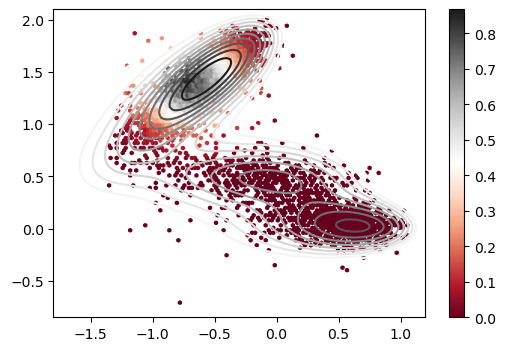

In [15]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

def muller_brown_potential(x, y):
    """Muller-Brown analytical potential"""
    prefactor = 0.15
    A = (-200, -100, -170, 15)
    a = (-1, -1, -6.5, 0.7)
    b = (0, 0, 11, 0.6)
    c = (-10, -10, -6.5, 0.7)
    x0 = (1, 0, -0.5, -1)
    y0 = (0, 0.5, 1.5, 1)
    offset = -146.7

    v = -prefactor * offset
    for i in range(4):
        v += (
            prefactor
            * A[i]
            * np.exp(
                a[i] * (x - x0[i]) ** 2
                + b[i] * (x - x0[i]) * (y - y0[i])
                + c[i] * (y - y0[i]) ** 2
            )
        )
    return v
def plot_isolines_2D(
    function,
    component=None,
    limits=((-1.8, 1.2), (-0.4, 2.1)),
    num_points=(100, 100),
    mode="contourf",
    levels=12,
    cmap=None,
    colorbar=None,
    max_value=None,
    ax=None,
    **kwargs,
):
    """Plot isolines of a function/model in a 2D space."""

    # Define grid where to evaluate function
    if type(num_points) == int:
        num_points = (num_points, num_points)
    xx = np.linspace(limits[0][0], limits[0][1], num_points[0])
    yy = np.linspace(limits[1][0], limits[1][1], num_points[1])
    xv, yv = np.meshgrid(xx, yy)



    z = function(xv, yv)

    if max_value is not None:
        z[z > max_value] = max_value

    # Setup plot
    return_axs = False
    if ax is None:
        return_axs = True
        _, ax = plt.subplots(figsize=(6, 4.0), dpi=100)

    # Color scheme
    if cmap is None:
        if mode == "contourf":
            cmap = "fessa"
        elif mode == "contour":
            cmap = "Greys_r"

    # Colorbar
    if colorbar is None:
        if mode == "contourf":
            colorbar = True
        elif mode == "contour":
            colorbar = False

    # Plot
    if mode == "contourf":
        pp = ax.contourf(xv, yv, z, levels=levels, cmap=cmap, **kwargs)
        if colorbar:
            plt.colorbar(pp, ax=ax)
    else:
        pp = ax.contour(xv, yv, z, levels=levels, cmap=cmap, **kwargs)

    if return_axs:
        return ax
    else:
        return None


#plt.scatter(np.squeeze(train_data[:,:1, ...]),vecs[:,-4]/vecs[:,-1],label="PCR generator first eigenfunction")
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour')
plt.hexbin(train_data[:,0, 2],train_data[:,0,3],C=model.kernel_X[:,0],cmap='RdGy')

plt.colorbar()



In [16]:

def compute_cv_on_grid(model1,gen=True,num=2):
    limits=((-1.8,1.2),(-0.4,2.1))
    num_points=(100,100)

    xx = np.linspace(limits[0][0],limits[0][1],num_points[0])
    yy = np.linspace(limits[1][0],limits[1][1],num_points[1])
    xv, yv = np.meshgrid(xx, yy)

    z = np.zeros((100,100))
    for i in tqdm.tqdm(range(100)):
        for j in range(100):
            vector = [0.0,0.0,xv[i,j], yv[i,j]]
            xy = np.array(vector).reshape(1,1,4)
            val_gen,vec_gen = model1.eig(eval_right_on=xy)
            if gen== True:
                if num !=1:
                    z[i,j] = (vec_gen[0,-num]/vec_gen[:,-1]).real
                else:
                    z[i,j] = vec_gen[0,-num]
            #grads[i,j]=torch.sum(torch.abs(torch.autograd.grad(z[i,j],xy)[0][0]))
    return xv,yv,z
xv,yv,cv1= compute_cv_on_grid(model,num=1)
xv,yv,cv2= compute_cv_on_grid(model,num=2)


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1752088/2959368183.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  z[i,j] = vec_gen[0,-num]
  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1752088/2959368183.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = (vec_gen[0,-num]/vec_gen[:,-1]).real
100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


-0.0
-1.0


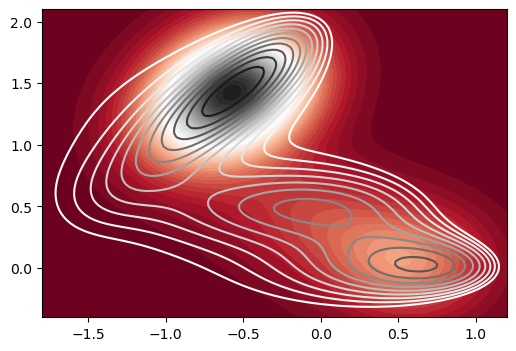

In [17]:
fig, ax = plt.subplots(figsize=(6,4))
ax.contourf(xv, yv, cv1, levels=50,cmap='RdGy')
cv1 = (cv1 - cv1.min())/(cv1.min()-cv1.max())
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
#plt.scatter(np.squeeze(train_data[:,:1, 0]),np.squeeze(train_data[:,:1, 1]),c=vecs_gen[:,-1],label="PCR generator first eigenfunction")
print(cv1.max())
print(cv1.min())

-0.0
-1.0


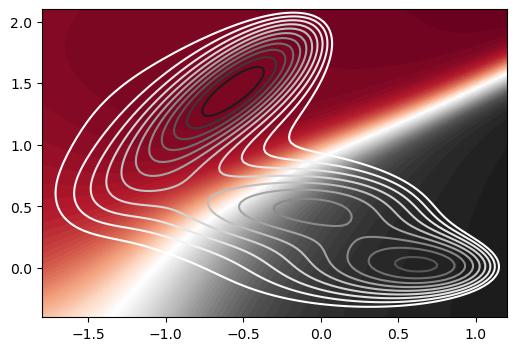

In [18]:
fig, ax = plt.subplots(figsize=(6,4))
ax.contourf(xv, yv, cv2, levels=100,cmap='RdGy')
cv2 = (cv2 - cv2.min())/(cv2.min()-cv2.max())
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
#plt.scatter(np.squeeze(train_data[:,:1, 0]),np.squeeze(train_data[:,:1, 1]),c=vecs_gen[:,-1],label="PCR generator first eigenfunction")
print(cv2.max())
print(cv2.min())
